In [ ]:
# libraries
import pandas as pd
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset

In [2]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
def robust_scale(x, eps=1e-6):
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    return (x - median) / (mad + eps)

class PeakDataset(Dataset):
    def __init__(self, csv_files):
        self.samples = []
        for csv_path in csv_files:
            df = pd.read_csv(csv_path, sep=";")

            for ch in ["channel_1", "channel_2", "channel_3",
                       "channel_4", "channel_5"]:

                x = df[ch].values.astype(np.float32)
                # sécurité longueur
                assert len(x) == 4961

                x = robust_scale(x)

                # shape (1, 4969)
                x = torch.from_numpy(x).unsqueeze(0)

                self.samples.append(x)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [24]:
from torch.utils.data import DataLoader

csv_files = list(Path("../Data/synthetic_ce_outputs_v5/csv").glob("*.csv"))
#number of files in the folder
print(f"Number of CSV files found: {len(csv_files)}")
dataset = PeakDataset(csv_files)

print(type(dataset))
print(len(dataset))
loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

Number of CSV files found: 40
<class '__main__.PeakDataset'>
200


In [34]:
!pip install matplotlib

  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (5.0 MB)
Using ca

/home/frederic/Documents/Fil_rouge/cirse/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 1, 4961])
tensor([[1.8119, 1.2116, 1.1704,  ..., 0.7999, 1.9587, 1.1202]])
4961


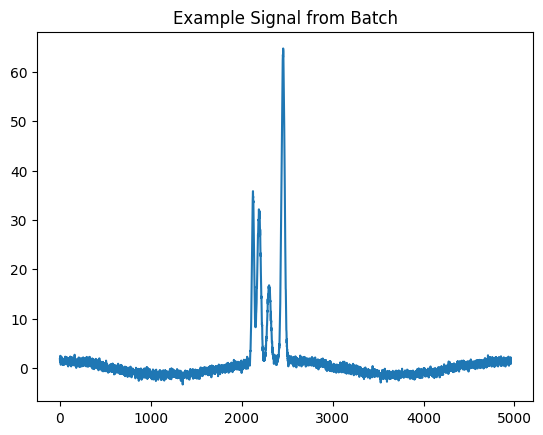

In [35]:
#visualisation d'un batch
for batch in loader:
    print(batch.shape)
    print(batch[0])
    print(len(batch[0][0]))
    break

# Example output:
# torch.Size([16, 1, 4961])

#plot d'un signal
import matplotlib.pyplot as plt
plt.plot(batch[0][0].numpy())
plt.title("Example Signal from Batch")
plt.show()